# Xception

End-to-end Xception training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## CassavaDiseaseDataset

In [2]:
TRAIN_DIR = 'dataset/cassava/train'
TEST_DIR = 'dataset/cassava/test'

In [3]:
classes = os.listdir(TRAIN_DIR)
print(classes)

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


Reading the images and storing them into a list

In [4]:
train_dataset = []
class_count = 0
dimension = (224, 224)

for leaf_class in classes:
    img_list = [f'{TRAIN_DIR}/{leaf_class}/{img}' for img in os.listdir(f'{TRAIN_DIR}/{leaf_class}')]
    
    for img_path in tqdm(img_list):  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)
        img = img_to_array(img)
        img = img / 255
        
        train_dataset.append([img, class_count])
        
    class_count += 1
    
test_dataset = []
class_count = 0
dimension = (224, 224)

for leaf_class in classes:
    img_list = [f'{TEST_DIR}/{leaf_class}/{img}' for img in os.listdir(f'{TEST_DIR}/{leaf_class}')]
    
    for img_path in tqdm(img_list):  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)
        img = img_to_array(img)
        img = img / 255
        
        test_dataset.append([img, class_count])
        
    class_count += 1

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/1533 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

  0%|          | 0/9211 [00:00<?, ?it/s]

  0%|          | 0/1804 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/3947 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

In [5]:
print("train: " + str(len(train_dataset)))
print("test: " + str(len(test_dataset)))

train: 14980
test: 6417


Doing the same thing to the test set

In [6]:
train_data, train_labels = zip(*train_dataset)
test_data, test_labels = zip(*test_dataset)

In [7]:
data = np.array(train_data)
labels = to_categorical(train_labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = 42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10486, 224, 224, 3)
(4494, 224, 224, 3)
(10486, 5)
(4494, 5)


The testing data will be used for testing after training the model

In [10]:
testX = np.array(test_data)
testy = to_categorical(test_labels)

In [11]:
print(testX.shape)
print(testy.shape)

(6417, 224, 224, 3)
(6417, 5)


## Model Training without Data Augmentation

In [24]:
from tensorflow.keras.applications import Xception

In [25]:
pretrained_model = Xception(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
pretrained_model.trainable = True

83683744/83683744 [==============================] - 13s 0us/step


In [26]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(6, activation = 'relu')(pretrained_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [27]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.0001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [early_stopper, reduce_lr])

Epoch 1/30
328/328 [==============================] - 2761s 8s/step - loss: 0.8989 - accuracy: 0.6727 - val_loss: 1.2041 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 2/30
328/328 [==============================] - 2737s 8s/step - loss: 0.6606 - accuracy: 0.7610 - val_loss: 2.0684 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 3/30
328/328 [==============================] - 2738s 8s/step - loss: 0.5529 - accuracy: 0.8060 - val_loss: 0.7293 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 4/30
328/328 [==============================] - 2769s 8s/step - loss: 0.4563 - accuracy: 0.8393 - val_loss: 0.7159 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 5/30
328/328 [==============================] - 2737s 8s/step - loss: 0.3918 - accuracy: 0.8622 - val_loss: 1.0856 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 6/30
328/328 [==============================] - 2847s 9s/step - loss: 0.3310 - accuracy: 0.8848 - val_loss: 1.2979 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 7/30
328/328 [==============================] - ETA:

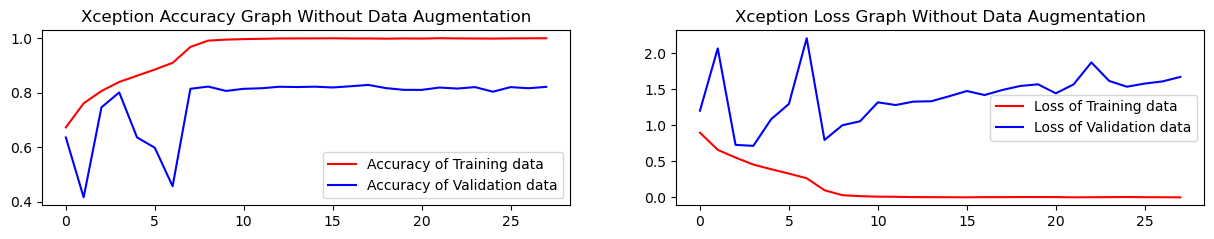

In [28]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(early_stopper.stopped_epoch + 1)

plt.figure(figsize = (15, 5))
plt.subplot(221)
plt.plot(epochs, train_acc, 'r', label = 'Accuracy of Training data')
plt.plot(epochs, val_acc, 'b', label = 'Accuracy of Validation data')
plt.title('Xception Accuracy Graph Without Data Augmentation')
plt.legend()

plt.subplot(222)
plt.plot(epochs, train_loss, 'r', label = 'Loss of Training data')
plt.plot(epochs, val_loss, 'b', label = 'Loss of Validation data')
plt.title('Xception Loss Graph Without Data Augmentation')
plt.legend()
plt.show()

In [29]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test accuracy:', score[1])

141/141 [==============================] - 223s 2s/step - loss: 1.4918 - accuracy: 0.8284
Test accuracy: 0.8284379243850708


In [30]:
predy = model.predict(testX)
pred = np.argmax(predy, axis = 1)
ground = np.argmax(testy, axis = 1)
print(classification_report(ground, pred))

201/201 [==============================] - 328s 2s/step
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       326
           1       0.76      0.68      0.72       656
           2       0.75      0.57      0.65       715
           3       0.91      0.96      0.93      3947
           4       0.61      0.65      0.63       773

    accuracy                           0.83      6417
   macro avg       0.71      0.68      0.69      6417
weighted avg       0.82      0.83      0.82      6417



In [31]:
model.save('C:/Users/niko/Quinito/Work/output/model/Xception.h5')